# Instrumentation Design 1
## Lab 5 - DC-Circuits Theorems, Part 1

Lab report by Matt Rixman

### 1. Solving circuits using mesh currents

Objective 1: To learn what is meant by a linear circuit

Objective 2: To verify experimentally the currents calculated by the mesh current method

1-4.  The following resistors were arranged according to Figure 1.4. The power supply was set at 10V each resistor's voltage drop was measured.

In [1]:
# nothing to see here
import pandas as pd
from si_prefix import si_format
from IPython.display import display
from sympy import symbols, Eq

def display_frame(frame):
    display(frame.applymap(lambda x: si_format(x, precision=2)))

r1, r2, r3, r4, r5, r6, rload = symbols('R_1 R_2 R_3 R_4 R_5 R_6 R_load')

circuit = pd.DataFrame.from_dict({
    r1: [1000, 5.62],
    r2: [1000, 4.11],
    r3: [1000, 1.54],
    r4: [1000, 1.03],
    r5: [1000, 0.51],
    r6: [1000, 1.53],
    rload: [1000, 0.51]
}, orient='index', columns=["ohms", "volts"])
display_frame(circuit)

,ohms,volts
R_1,1.00 k,5.62
R_2,1.00 k,4.11
R_3,1.00 k,1.54
R_4,1.00 k,1.03
R_5,1.00 k,510.00 m
R_6,1.00 k,1.53
R_load,1.00 k,510.00 m


5. From these voltages we can determine the currents through each resistor

In [2]:
circuit['amps'] = circuit.apply(lambda x: x["volts"]/x["ohms"], axis=1)
display_frame(circuit)

,ohms,volts,amps
R_1,1.00 k,5.62,5.62 m
R_2,1.00 k,4.11,4.11 m
R_3,1.00 k,1.54,1.54 m
R_4,1.00 k,1.03,1.03 m
R_5,1.00 k,510.00 m,510.00 µ
R_6,1.00 k,1.53,1.53 m
R_load,1.00 k,510.00 m,510.00 µ


6. Before we calculate the mesh currents, let's name some points so that directionality is easy to talk about

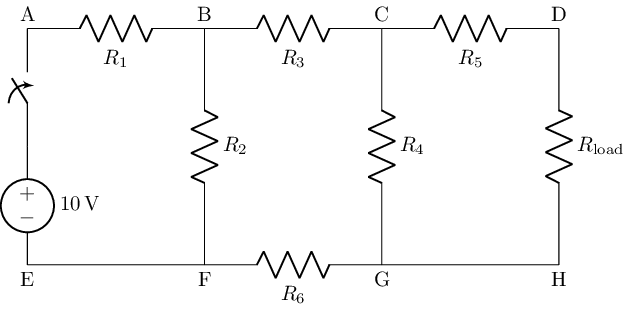

In [3]:
from lcapy import Circuit
Circuit("""
V 1 6 {10}; down
SW 1 2 no; up
R1 2 3; right=1.5
R3 3 4; right=1.5
R5 4 5; right=1.5
W 6 7; right
R6 7 8; right
W 8 9; right
Rload 9 5; up
R2 3 7; down
R4 4 8; down
A1 2; l=A, anchor=south
A2 3; l=B, anchor=south
A3 4; l=C, anchor=south
A4 5; l=D, anchor=south
A6 6; l=E, anchor=north
A7 7; l=F, anchor=north
A8 8; l=G, anchor=north
A9 9; l=H, anchor=north
""").draw(label_ids=False, draw_nodes=False, label_nodes=False)

# lookups for mapping betwee resistors and their segments
vea, vab, vbc, vcd, vdh, vgf, vbf, vcg, vdh = \
    symbols('V_ea V_ab V_bc V_cd V_dh V_gf V_bf V_cg V_dh')
r2v = {
    r1 : vab,
    r2 : vbf,
    r3 : vbc,
    r4 : vcg,
    r5 : vcd,
    r6 : vgf,
    rload: vdh
}
v2r = { v: k for k, v in r2v.items() }

Ohms law gives the voltage of each segment in terms of the three mesh currents I<sub>left</sub>, I<sub>center</sub>, and I<sub>right</sub>.

In [4]:
from sympy import symbols, Eq         # used for algebra
from sympy.solvers import solve
ileft, icenter, iright = symbols('I_left, I_center, I_right')

segments = {
    vea : +10,
    vab : r1 * (-ileft),
    vbf : r2 * (-ileft + icenter),
    vbc : r3 * (-icenter),
    vcg : r4 * (-icenter + iright),
    vgf : r6 * (-icenter),
    vcd : r5 * (-iright),
    vdh : rload * (-iright)
}

segment_eq = {}
for segment, formula in segments.items():
    eq = Eq(segment, formula)
    display(eq)
    segment_eq[segment] = eq

Then we write equations for those mesh currents in terms of the voltage deltas.

In [5]:
# if the mesh current travels the opposite way, negate
segments[-vbf] = -1 * segments[vbf]
segments[-vcg] = -1 * segments[vcg]

mesh_paths = {
    ileft : [vea, vab, vbf],         # clockwise from E
    icenter: [-vbf, vbc, vcg, vgf],  # clockwise from F
    iright: [-vcg, vcd, vdh]         # clockwise from G
}

mesh_equation = {}
for current, path in mesh_paths.items():
    eq = Eq(current, sum(map(lambda segment: segments[segment], path)))
    display(eq)
    mesh_equation[current] = eq

And we solve the system

In [6]:
# also equate each resistor with its resistance (so we get numbers and not expressions)
resistor_symbols = [r1, r2, r3, r4, r5, r6, rload]
resistor_substitutions = map(lambda r: Eq(r, circuit["ohms"][r]), resistor_symbols)

# then solve the system of equations
solution = solve(list(mesh_equation.values()) \
                 + list(resistor_substitutions))[0]

# gather mesh currents
mesh_amps = { k : float(v) for k,v in solution.items() if k not in resistor_symbols }
pd.DataFrame.from_dict(
    {
        str(k): [si_format(v, precision=2)] for k,v in mesh_amps.items()
    }, orient="index", columns=["amps"])

,amps
I_center,1.58 m
I_left,5.79 m
I_right,525.65 µ


7-8 Using these values, we can calculate the voltage in each resistor

In [7]:
voltage_symbols = [vab, vbc, vcd, vdh, vgf, vbf, vcg, vdh]
subs = mesh_amps.copy()
subs.update({ r: circuit["ohms"][r] for r in resistor_symbols })
voltages = { v2r[symb]: abs(segments[symb].evalf(subs=subs)) for symb in voltage_symbols }
circuit['volts_calculated'] = circuit.apply(lambda x: voltages[x.name], axis=1)
display_frame(circuit)

,ohms,volts,amps,volts_calculated
R_1,1.00 k,5.62,5.62 m,5.79
R_2,1.00 k,4.11,4.11 m,4.21
R_3,1.00 k,1.54,1.54 m,1.58
R_4,1.00 k,1.03,1.03 m,1.05
R_5,1.00 k,510.00 m,510.00 µ,525.65 m
R_6,1.00 k,1.53,1.53 m,1.58
R_load,1.00 k,510.00 m,510.00 µ,525.65 m


From there, we can get the amps through each resistor  (adding the mesh currents would've worked too, but the data was handy to do it this way...)

In [8]:
circuit['amps_calculated'] = circuit.apply(lambda x: x["volts_calculated"]/x["ohms"], axis=1)
display_frame(circuit)

,ohms,volts,amps,volts_calculated,amps_calculated
R_1,1.00 k,5.62,5.62 m,5.79,5.79 m
R_2,1.00 k,4.11,4.11 m,4.21,4.21 m
R_3,1.00 k,1.54,1.54 m,1.58,1.58 m
R_4,1.00 k,1.03,1.03 m,1.05,1.05 m
R_5,1.00 k,510.00 m,510.00 µ,525.65 m,525.65 µ
R_6,1.00 k,1.53,1.53 m,1.58,1.58 m
R_load,1.00 k,510.00 m,510.00 µ,525.65 m,525.65 µ


### 2. Balanced Bridge Circuit

Objective 1: To find the relationship among the resistors in a blanaced-bridge circuit

Objective 2: To use the relationship among resistors in a balanced bridge circuit to measure an unknown resistance

1-6. The circuit in figure 2.3 was assembled to include a mystery resistor.  The bridge was brought into balance and the mystery resistor's resistance was calculated:

In [9]:
r1, r2, pot, rbridge, rmm, rmn = symbols('R_1 R_2 Pot R_bridge R_mystery_measured R_mystery_nominal')
resistors = [r1, r2, pot, rbridge, rmm, rmn]
ohms = {r1 : 5.1e3, r2: 5.1e3, rbridge: 1.49e3, pot:1.49e3, rmn:1.50e3}

def show_balanced(ohms):
    # use the wheatstone bridge formula to calculate the mystery resistor
    balance_eq = Eq(rmm, pot * (r2 / r1))
    ohms[rmm] =  solve(balance_eq, rmm)[0].evalf(subs=ohms)

    circuit = pd.DataFrame.from_dict({ r: ohms[r] for r in resistors if r != rbridge },
                                     orient="index", columns=["ohms"])
    display_frame(circuit)
    
show_balanced(ohms)

,ohms
R_1,5.10 k
R_2,5.10 k
Pot,1.49 k
R_mystery_measured,1.49 k
R_mystery_nominal,1.50 k


7. The previous procedure was repeated for five additional resistors

In [10]:
sample_resistors = symbols(' '.join([f"R_mystery_{r}" for r in range(2, 7)]))
ohms_nominal = [10e3, 3.3e3, 330, 6.8e3, 180]
ohms_measured = [9.68e3, 3.25e3, 310, 6.87e3, 182]
balances = pd.DataFrame.from_dict(
    { r : [ohms_nominal[i], ohms_measured[i]] for i, r in enumerate(sample_resistors)},
    orient="index", columns=["ohms_nominal", "ohms_measured"]
)
display_frame(balances)

,ohms_nominal,ohms_measured
R_mystery_2,10.00 k,9.68 k
R_mystery_3,3.30 k,3.25 k
R_mystery_4,330.00,310.00
R_mystery_5,6.80 k,6.87 k
R_mystery_6,180.00,182.00


9-11. To widen the measurable range of our bridge to 30Ω, a new value for r2 and a new mystery resistor was chosen.  The bridge was rebalanced, which gave the following results:

In [11]:
ohms[r2] = 15.3e3
ohms[pot] = 9.6e3
ohms[rmn] = 27
show_balanced(ohms)

,ohms
R_1,5.10 k
R_2,15.30 k
Pot,9.60 k
R_mystery_measured,28.80 k
R_mystery_nominal,27.00


12-13. To further widen its range to 100Ω, new values of both r1 and r2 were chosen.  The bridge was rebalanced, which gave the following results:

In [12]:
ohms[r1] = 1e3
ohms[r2] = 100e3
ohms[pot] = 207
ohms[rmn] = 22e3
show_balanced(ohms)

,ohms
R_1,1.00 k
R_2,100.00 k
Pot,207.00
R_mystery_measured,20.70 k
R_mystery_nominal,22.00 k


### 3. Superposition Theorem
Objective 1: To verify experimentally the superposition theorem

1-4. The circuit show below was assembled, and three configurations were measured:

- 10V power supply omitted (a wire in its place)
- 15V power suppply ommitted (a wire in its place)
- both power supplies included

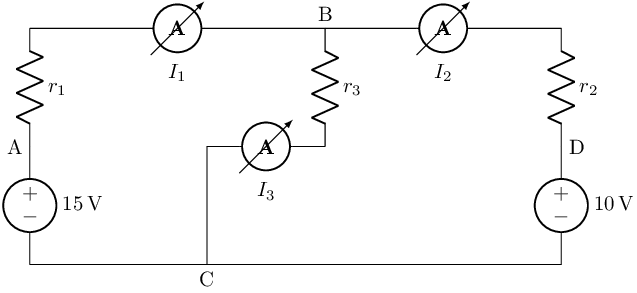

In [13]:
Circuit("""
R1 1 2 {820}; up, l=r_1
AM1 2 3; right=2.5, l=I_1
AM2 3 4; right=2, l=I_2
R3 3 5 {1200}; down, l=r_3
AM3 13 5; l=I_3
R2 4 6 {2200}; down, l=r_2
V2 6 7 {10}; down
V1 1 11 {15}; down
W 11 8; right=1.5
W 13 8; down
W 8 7; right
A 1; anchor=east, l=A
A 3; anchor=south, l=B
A 8; anchor=north, l=C
A 6; anchor=west, l=D
""").draw(label_ids=False, draw_nodes=False, label_nodes=False)

In [14]:
ohms = pd.DataFrame.from_dict({r1: 820, r2:1200, r3:2200}, orient='index', columns=["resistance (Ω)"])
display(ohms)

,resistance (Ω)
R_1,820
R_2,1200
R_3,2200


These measurements were captured:

In [75]:
columns = ["I1 (A)", "I2 (A)", "I3 (A)", "V_R1 (V)", "V_R2 (V)", "V_R3 (V)"]
values = pd.DataFrame.from_dict({"15V only":  [ 9.45e-3,  6.11e-3, 3.23e-3, 7.76,  7.32,  7.32], 
                                 "10V only":   [3.81e-3,  5.57e-3, 1.47e-3, 3.32, 6.66, 3.32,], 
                                 "both included": [13.5e-3,  11.69e-3, -1.76e-3, 11.07, 13.97, -3.98]}, 
                                orient="index",
                                columns=columns)

display_frame(values)

,I1 (A),I2 (A),I3 (A),V_R1 (V),V_R2 (V),V_R3 (V)
15V only,9.45 m,6.11 m,3.23 m,7.76,7.32,7.32
10V only,3.81 m,5.57 m,1.47 m,3.32,6.66,3.32
both included,13.50 m,11.69 m,-1.76 m,11.07,13.97,-3.98


5. Calculations appear below

In [78]:
ileft, vab, vbc, vca = symbols("I_left V_ab V_bc V_ca")
iright, vcb, vbd, vdc = symbols("I_right V_cb V_bd V_dc")

system = {
    # voltage deltas
    vca : +15,
    vab : r1 * (-ileft),
    vbc : r3 * (-ileft + iright),
    vcb : -vbc,
    vbd : r2 * (-iright),
    vdc : 0,
    
    # resistor values
    r1 : ohms['resistance (Ω)'][r1],
    r2 : ohms['resistance (Ω)'][r2],
    r3 : ohms['resistance (Ω)'][r3],
}

def calculate(name, left_ps, right_ps):
    
    system_modified = system.copy()
    system_modified[vca] = left_ps
    system_modified[vdc] = right_ps

    # solve the above system, plus kirchoff's voltage laws
    # (not included because 0 would be used twice as a dict key)
    solution = solve([Eq(lhs, rhs) for lhs, rhs in system_modified.items()] \
          + [Eq(0, vab + vbc + vca), Eq(0, vcb + vbd + vdc)])

    # extract currents and voltages
    amps = {i : float(solution[0][i]) for i in [ileft, iright]}
    volts = {v : float(solution[0][v]) for v in [vab, vbd, vbc]}

    result = pd.DataFrame.from_dict(
        {
            name: 
            [amps[ileft], amps[iright], amps[ileft] - amps[iright],
             volts[vab], volts[vbd], volts[vbc]]
        }, orient="index", columns=columns)
    return result
    
# calculate with 15 v
left_only = calculate("15V only (calculated)", 15, 0)

# calculate with 10 v
right_only = calculate("10V only (calculated)", 0, 10)

# calculate with both via superposition theorem
superposition = result = pd.DataFrame.from_dict(
        {
            "both included (calculated via superposition)": 
            [ left_only[c][0] + right_only[c][0] for c in columns]
        }, orient="index", columns=columns)

all_together = pd.concat([values, left_only, right_only, superposition])
display_frame(all_together.sort_index())



,I1 (A),I2 (A),I3 (A),V_R1 (V),V_R2 (V),V_R3 (V)
10V only,3.81 m,5.57 m,1.47 m,3.32,6.66,3.32
10V only (calculated),4.05 m,5.56 m,-1.51 m,-3.32,-6.68,3.32
15V only,9.45 m,6.11 m,3.23 m,7.76,7.32,7.32
15V only (calculated),9.40 m,6.08 m,3.32 m,-7.70,-7.30,-7.30
both included,13.50 m,11.69 m,-1.76 m,11.07,13.97,-3.98
both included (calculated via superposition),13.45 m,11.64 m,1.81 m,-11.03,-13.97,-3.97


6. Until this lab, we had manged to get away with language like: 
> Voltage across r<sub>1</sub>

We had assumped that negative signs could be ignored.  This lab showed us the problem with that method of capturing results.  If you look at only absolute values, our measurements agree with our calculations.

But occasionally, the calculation provides a meaningful negative sign, which did not show up in the measurement.  This could have been avoided if we had instead used language like:
> Voltage from A to B

which would remove the directional ambiguity from our measurements.